In [138]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
import joblib

In [2]:
df = pd.read_csv('desafio_indicium_imdb.csv', index_col=0)

## 1. EDA

In [3]:
# Visão geral de informações relevantes
data_overview = pd.DataFrame({
    "Tipo": df.dtypes,
    "Nulos": df.isnull().sum(),
    "% Nulos": df.isnull().mean()*100,
    "Valores Únicos": df.nunique(),
    "Exemplo de Valores": df.apply(lambda x: ", ".join([str(v) for v in x.dropna().unique()[:3]])),
})
data_overview

,Tipo,Nulos,% Nulos,Valores Únicos,Exemplo de Valores
Series_Title,object,0,0.000000,998,"The Godfather, The Dark Knight, The Godfather:..."
Released_Year,object,0,0.000000,100,"1972, 2008, 1974"
Certificate,object,101,10.110110,16,"A, UA, U"
Runtime,object,0,0.000000,140,"175 min, 152 min, 202 min"
Genre,object,0,0.000000,202,"Crime, Drama, Action, Crime, Drama, Action, Ad..."
IMDB_Rating,float64,0,0.000000,16,"9.2, 9.0, 8.9"
Overview,object,0,0.000000,999,An organized crime dynasty's aging patriarch t...
Meta_score,float64,157,15.715716,63,"100.0, 84.0, 90.0"
Director,object,0,0.000000,548,"Francis Ford Coppola, Christopher Nolan, Sidne..."
Star1,object,0,0.000000,659,"Marlon Brando, Christian Bale, Al Pacino"


In [4]:
# Limpando potenciais espaços desnecessários nos nomes das colunas, caso existam
df.columns = df.columns.str.strip()
# Linhas e Colunas
print(f"{df.shape[0]} linhas & {df.shape[1]} colunas")
# Verificando duplicadas
print("Duplicadas:", df.duplicated().sum())

999 linhas & 15 colunas
Duplicadas: 0


In [5]:
# Transformando variáveis para numéricas e fazendo as limpezas necessárias
df["Gross"] = pd.to_numeric(df["Gross"].str.replace(",", ""), errors="coerce")
df["Runtime"] = pd.to_numeric(df["Runtime"].str.replace(" min", ""), errors="coerce")
df["Released_Year"] = pd.to_numeric(df["Released_Year"], errors="coerce").astype("Int64")

In [6]:
df.head(5)

,Series_Title,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross
1,The Godfather,1972,A,175,"Crime, Drama",9.2,An organized crime dynasty's aging patriarch t...,100.0,Francis Ford Coppola,Marlon Brando,Al Pacino,James Caan,Diane Keaton,1620367,134966411.0
2,The Dark Knight,2008,UA,152,"Action, Crime, Drama",9.0,When the menace known as the Joker wreaks havo...,84.0,Christopher Nolan,Christian Bale,Heath Ledger,Aaron Eckhart,Michael Caine,2303232,534858444.0
3,The Godfather: Part II,1974,A,202,"Crime, Drama",9.0,The early life and career of Vito Corleone in ...,90.0,Francis Ford Coppola,Al Pacino,Robert De Niro,Robert Duvall,Diane Keaton,1129952,57300000.0
4,12 Angry Men,1957,U,96,"Crime, Drama",9.0,A jury holdout attempts to prevent a miscarria...,96.0,Sidney Lumet,Henry Fonda,Lee J. Cobb,Martin Balsam,John Fiedler,689845,4360000.0
5,The Lord of the Rings: The Return of the King,2003,U,201,"Action, Adventure, Drama",8.9,Gandalf and Aragorn lead the World of Men agai...,94.0,Peter Jackson,Elijah Wood,Viggo Mortensen,Ian McKellen,Orlando Bloom,1642758,377845905.0


In [7]:
# Verificando se os únicos filmes com exato mesmo nome eram um erro de registro, demonstram ser filmes diferentes!
df[df["Series_Title"] == "Drishyam"]

,Series_Title,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross
87,Drishyam,2013,U,160,"Crime, Drama, Thriller",8.3,A man goes to extreme lengths to save his fami...,NaN,Jeethu Joseph,Mohanlal,Meena,Asha Sharath,Ansiba,30722,NaN
136,Drishyam,2015,UA,163,"Crime, Drama, Mystery",8.2,Desperate measures are taken by a man who trie...,NaN,Nishikant Kamat,Ajay Devgn,Shriya Saran,Tabu,Rajat Kapoor,70367,739478.0


## Análise de variáveis

### Released Year

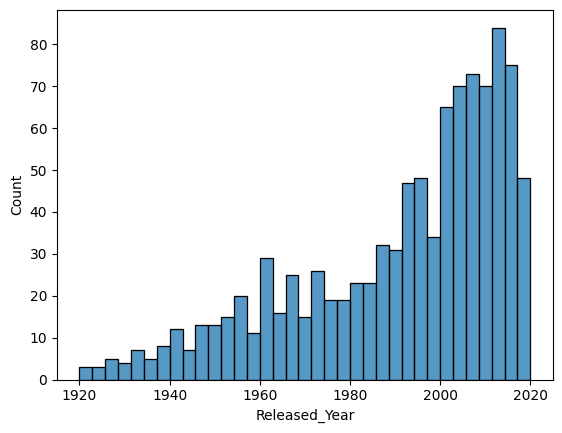

count          998.0
mean     1991.214429
std        23.308539
min           1920.0
25%           1976.0
50%           1999.0
75%           2009.0
max           2020.0
Name: Released_Year, dtype: Float64

In [8]:
anos = df["Released_Year"]

sns.histplot(anos.dropna(), bins=35)
plt.show()

anos.describe()

A base traz filmes cujos lançamentos datam de 1920 até 2020.
50% dos filmes tiveram seus lançamentos de 1999 até 2020.

Uma variável que pode ser usada, por exemplo, para verificar diferença do faturamento ao longo dos anos ou se filmes mais antigos possuem uma nota metascore ou imdb maior que os filmes mais atuais.

### Genre

In [9]:
# Separando os gêneros de filme para contagem de aparições individuais de cada um
df["Genre_list"] = df["Genre"].str.split(", ")
df_xgenre = df.explode("Genre_list")

genre = df_xgenre["Genre_list"]

absolute_values = genre.value_counts()
relative_values = (absolute_values/len(df))*100

absolute_values, relative_values


(Genre_list
 Drama        723
 Comedy       233
 Crime        209
 Adventure    196
 Action       189
 Thriller     137
 Romance      125
 Biography    109
 Mystery       99
 Animation     82
 Sci-Fi        67
 Fantasy       66
 History       56
 Family        56
 War           51
 Music         35
 Horror        32
 Western       20
 Film-Noir     19
 Sport         19
 Musical       17
 Name: count, dtype: int64,
 Genre_list
 Drama        72.372372
 Comedy       23.323323
 Crime        20.920921
 Adventure    19.619620
 Action       18.918919
 Thriller     13.713714
 Romance      12.512513
 Biography    10.910911
 Mystery       9.909910
 Animation     8.208208
 Sci-Fi        6.706707
 Fantasy       6.606607
 History       5.605606
 Family        5.605606
 War           5.105105
 Music         3.503504
 Horror        3.203203
 Western       2.002002
 Film-Noir     1.901902
 Sport         1.901902
 Musical       1.701702
 Name: count, dtype: float64)

Uma grande porcentagem (72.37%) dos filmes possuem atribuído o gênero "Drama", seguido por Comédia (23.32%), Crime (20.92%), Aventura (19.62%), Ação (18.92%) entre outros.

Ao total são 21 gêneros únicos que podem ser atribuídos a um filme, cada filme pode possuir diversos marcadores de gêneros ao mesmo tempo.

É uma variável que pode segmentar os filmes para compartivos de arrecadamento e também ao imdb rating e metascore. Está formatada de forma consistente.

### Certificate

In [10]:
df["Certificate"].value_counts()

Certificate
U           234
A           196
UA          175
R           146
PG-13        43
PG           37
Passed       34
G            12
Approved     11
TV-PG         3
GP            2
TV-14         1
Unrated       1
TV-MA         1
16            1
U/A           1
Name: count, dtype: int64

Variável que segmenta os filmes pela classificação etária. Pode ser feito um comparativo entre restrição de público e arrecadamento.

Nota-se que uma entrada "U/A" possivelmente foi formatada de forma não consistente em relação às 175 entradas formatadas em "UA"

### IMDB_Rating

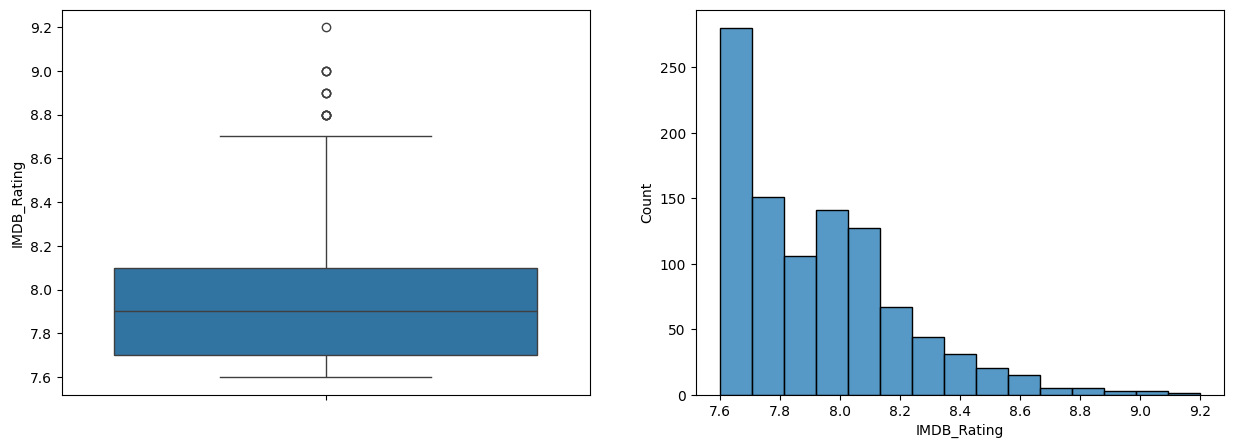

count    999.000000
mean       7.947948
std        0.272290
min        7.600000
25%        7.700000
50%        7.900000
75%        8.100000
max        9.200000
Name: IMDB_Rating, dtype: float64

In [11]:
imdb_rating = df["IMDB_Rating"]

desc = imdb_rating.describe()

fig, (ax_box, ax_hist) = plt.subplots(
    nrows=1,
    ncols=2,
    figsize=(15,5)
)

sns.boxplot(imdb_rating, ax=ax_box)
sns.histplot(imdb_rating, ax=ax_hist, bins=15)
plt.show()

desc

IMDB_Rating é uma variável numérica que representa a pontuação IMDB do filme. Não demonstra valores faltantes

Principais estatísticas descritivas:
- Média: 7.948
- Desvio Padrão: 0.272
- Mediana: 7.9
- Valor mínimo: 7.6
- Valor maximo: 9.2

As pontuações IMDB dos filmes estão majoritariamente distribuidas no intervalo de 7.6 à 8.1 (75% dos filmes da base)
Nenhum filme na base possui pontuação menor de 7.6

### Runtime

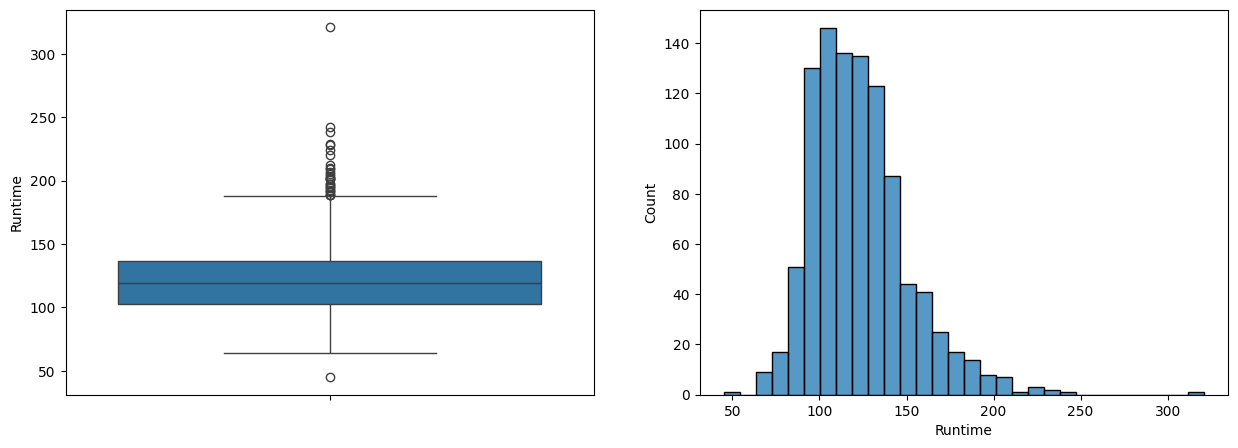

(count    999.000000
 mean     122.871872
 std       28.101227
 min       45.000000
 25%      103.000000
 50%      119.000000
 75%      137.000000
 max      321.000000
 Name: Runtime, dtype: float64,
 np.float64(1.2098770751975365))

In [12]:
runtime = df["Runtime"]

desc = runtime.describe()
skew = runtime.skew()

fig, (ax_box, ax_hist) = plt.subplots(
    nrows=1,
    ncols=2,
    figsize=(15,5)
)

sns.boxplot(runtime, ax=ax_box)
sns.histplot(runtime, ax=ax_hist, bins=30)
plt.show()

desc, skew

Runtime é a variável que indica a duração do filme em minutos. Não aparenta ter nenhum valor ausente

Principais estatísticas descritivas:
- Média: 122.87 minutos
- Desvio Padrão: 28.1 minutos
- Mediana: 119 minutos
- Valor mínimo: 45 minutos
- Valor Máximo: 321 minutos

Possui diversos valores outliers, em destaque o filme que tem 321 minutos de duração.  
A grande maioria dos filmes se encontra entre 100 até 137 minutos  
Skew de 1.20 demonstrando uma alta assimetria

### Metascore

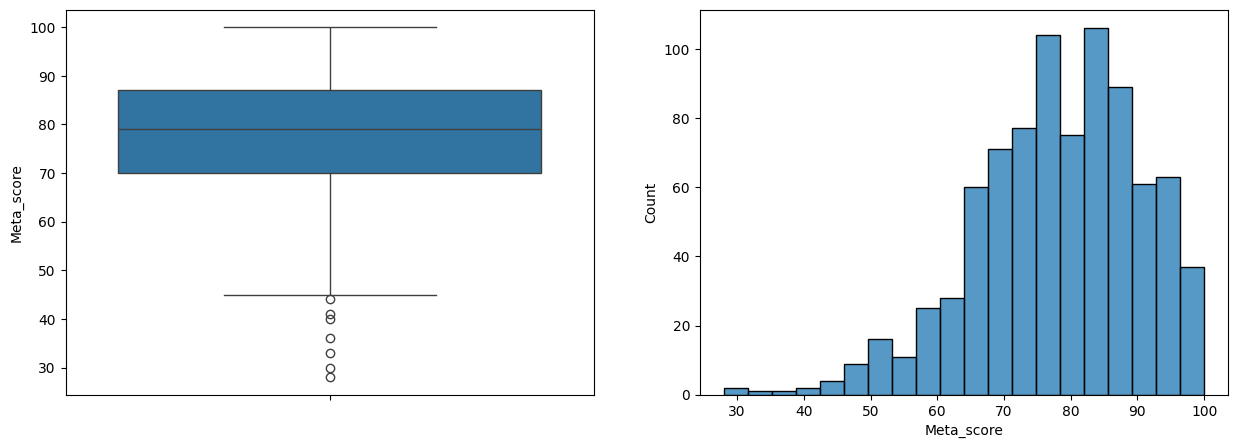

(count    842.000000
 mean      77.969121
 std       12.383257
 min       28.000000
 25%       70.000000
 50%       79.000000
 75%       87.000000
 max      100.000000
 Name: Meta_score, dtype: float64,
 np.int64(157),
 np.float64(-0.604316230073612))

In [68]:
metascore = df["Meta_score"]

desc = metascore.describe()
n_null = metascore.isnull().sum()
score_skew = metascore.skew()

fig, (ax_box, ax_hist) = plt.subplots(
    nrows=1,
    ncols=2,
    figsize=(15,5)
)

sns.boxplot(metascore, ax=ax_box)
sns.histplot(metascore, ax=ax_hist, bins=20)
plt.show()

desc, n_null, score_skew

Essa variável representa a pontuação metascore dos filmes.

Principais estatísticas descritivas:
- Média: 77.97
- Desvio Padrão: 12.38
- Mediana: 79
- Valor Mínimo: 28
- Valor Máximo: 100

Possui 157 valores faltantes. 

Esses valores nulos são erros de registro? São filmes muito antigos que não possuem avaliações no metacritic? São filmes que não possuem críticas suficientes para gerar o score?  
Há de ser explorado o padrão desses valores nulos para saber como lidar com eles

### No_of_Votes

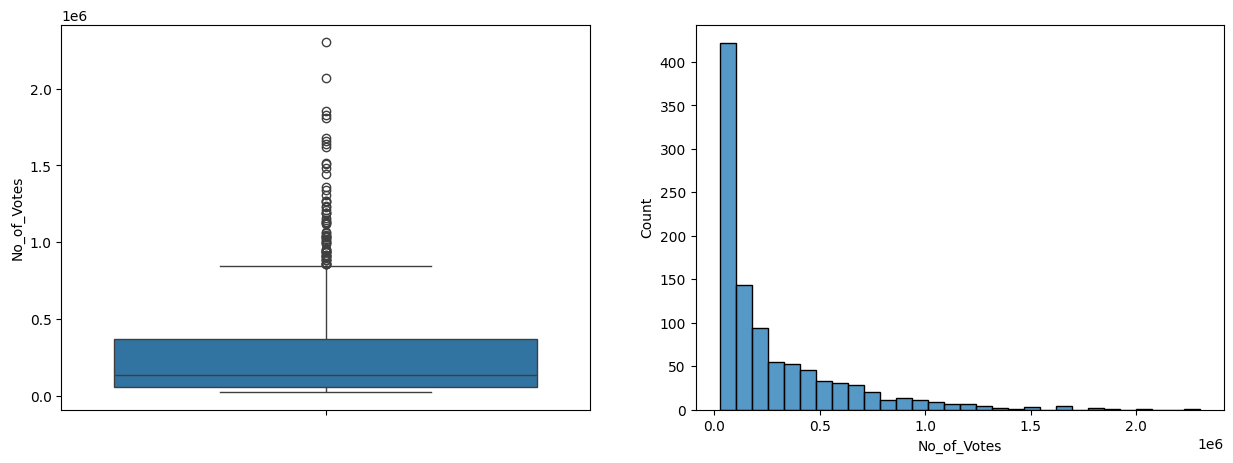

(count    9.990000e+02
 mean     2.716214e+05
 std      3.209126e+05
 min      2.508800e+04
 25%      5.547150e+04
 50%      1.383560e+05
 75%      3.731675e+05
 max      2.303232e+06
 Name: No_of_Votes, dtype: float64,
 np.int64(0))

In [14]:
votes = df["No_of_Votes"]

desc = votes.describe()
n_null = votes.isnull().sum()

fig, (ax_box, ax_hist) = plt.subplots(
    nrows=1,
    ncols=2,
    figsize=(15,5)
)

sns.boxplot(votes, ax=ax_box)
sns.histplot(votes, ax=ax_hist, bins=30)
plt.show()

desc, n_null

Skew antes da transformação: 2.194351089631736 | Skew depois da transformação: 0.22722021045481158


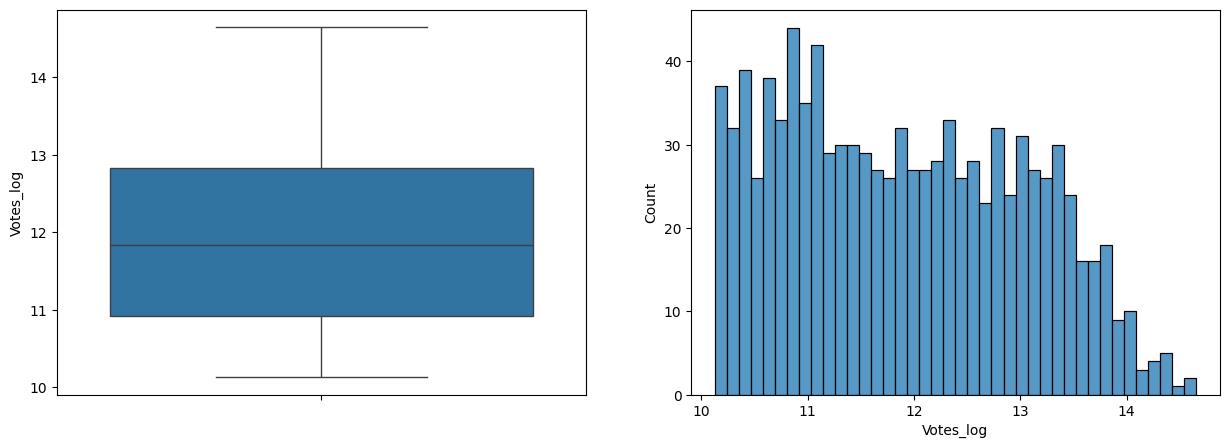

np.int64(0)

In [15]:
df["Votes_log"] = np.log1p(df["No_of_Votes"])

votes_log = df["Votes_log"]
votes_log_null = votes_log.isnull().sum()

print(f"Skew antes da transformação: {votes.skew()} | Skew depois da transformação: {votes_log.skew()}")

fig, (ax_box, ax_hist) = plt.subplots(
    nrows=1,
    ncols=2,
    figsize=(15,5)
)

sns.boxplot(votes_log, ax=ax_box)
sns.histplot(votes_log, ax=ax_hist, bins=40)
plt.show()

votes_log_null

Variável que apresenta o número de votos por usuários para o IMDB_Rating.  
A distribuição possui assimetria muito acentuada com um skew de 2.2. Com a transformação em log a assimetria foi para 0.227 (assimetria mais leve)

Principais estatísticas descritivas (aproximadamente, antes da transformação em log):
- Média: 271621.4 votos
- Desvio Padrão: 320912.6 votos
- Mediana: 138356 votos
- Valor mínimo: 25088 votos
- Valor máximo: 2303232 votos

Um volume maior de avaliações normalmente indica maior confiabilidade no rating final.  
Exemplo de um produto avaliado em 5 estrelas por 10 pessoas versus um produto 4.7 estrelas avaliado por 20000 pessoas  
No caso dos filmes, embora a grande disparidade entre quantidade de votos entre um filme e outro, o valor mínimo que aparece é igual a 25088 votos, que é um número estatisticamente razoável

### Gross

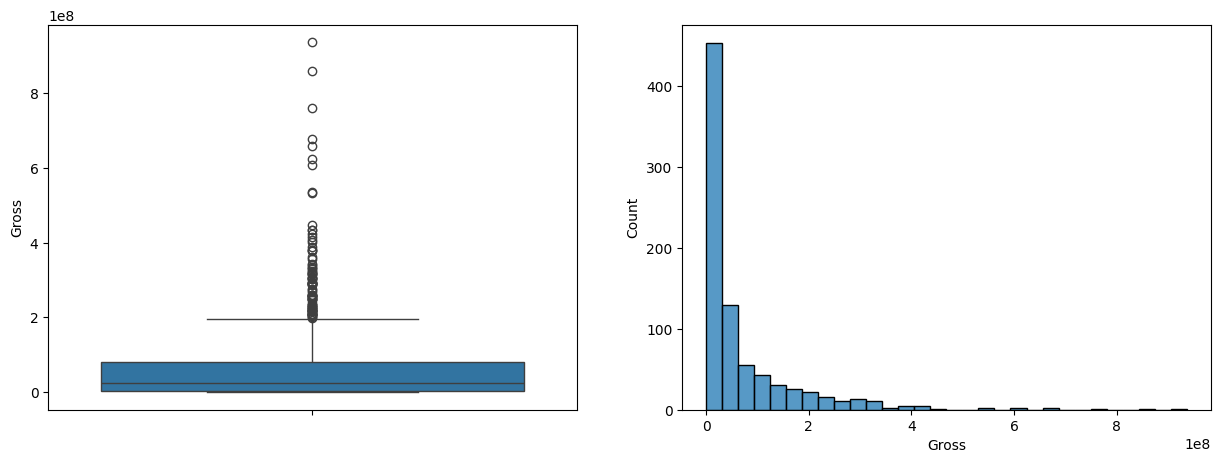

(count    8.300000e+02
 mean     6.808257e+07
 std      1.098076e+08
 min      1.305000e+03
 25%      3.245338e+06
 50%      2.345744e+07
 75%      8.087634e+07
 max      9.366622e+08
 Name: Gross, dtype: float64,
 np.int64(169))

In [16]:
gross = df["Gross"]

desc = gross.describe()
n_null = gross.isnull().sum()

fig, (ax_box, ax_hist) = plt.subplots(
    nrows=1,
    ncols=2,
    figsize=(15,5)
)

sns.boxplot(gross, ax=ax_box)
sns.histplot(gross, ax=ax_hist, bins=30)
plt.show()

desc, n_null

Skew antes da transformação: 3.127745173671789 | Skew depois da transformação: -0.8785538527797244


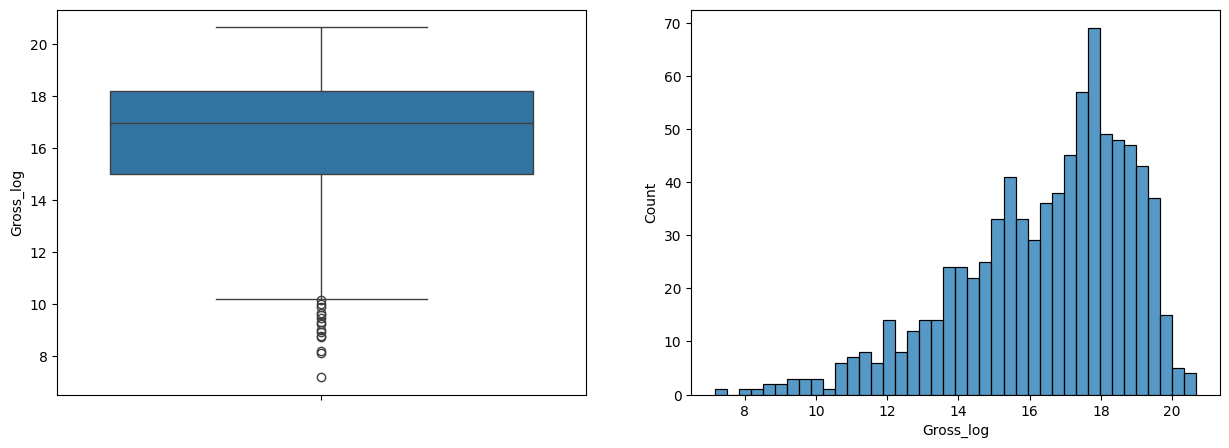

np.int64(169)

In [17]:
df["Gross_log"] = np.log1p(df["Gross"])

gross_log = df["Gross_log"]
gross_log_null = gross_log.isnull().sum()

print(f"Skew antes da transformação: {gross.skew()} | Skew depois da transformação: {gross_log.skew()}")

fig, (ax_box, ax_hist) = plt.subplots(
    nrows=1,
    ncols=2,
    figsize=(15,5)
)

sns.boxplot(gross_log, ax=ax_box)
sns.histplot(gross_log, ax=ax_hist, bins=40)
plt.show()

gross_log_null

Essa é a variável de faturamento. Possui 169 valores faltantes.  
Também possui uma assimetria muito grande com um skew = 3.127, após a transformação em log o skew fica aproximadamente -0.878, uma assimetria moderada.

Principais estatísticas descritivas (aproximadamente, antes da transformação em log):
- Média: $68082570
- Desvio Padrão: $109807600
- Mediana: $23457440
- Valor mínimo: $1305
- Valor máximo: $936662200

O faturamente pode ser relacionado com outras segmentações das variáveis categóricas.

## Análise bivariada

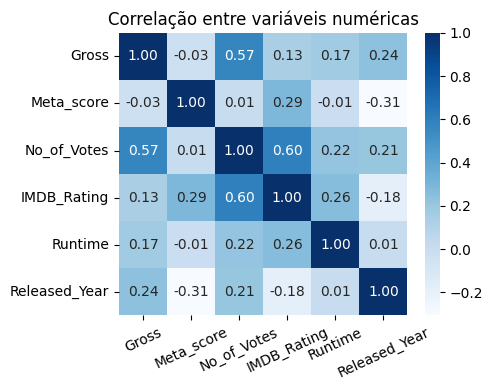

,Gross,Meta_score,No_of_Votes,IMDB_Rating,Runtime,Released_Year
Gross,1.000000,-0.030452,0.571753,0.133999,0.172700,0.235948
Meta_score,-0.030452,1.000000,0.008946,0.285910,-0.012383,-0.306415
No_of_Votes,0.571753,0.008946,1.000000,0.600363,0.216808,0.208311
IMDB_Rating,0.133999,0.285910,0.600363,1.000000,0.256602,-0.181447
Runtime,0.172700,-0.012383,0.216808,0.256602,1.000000,0.013033
Released_Year,0.235948,-0.306415,0.208311,-0.181447,0.013033,1.000000


In [18]:
num_vars = ['Gross', 'Meta_score', 'No_of_Votes', 'IMDB_Rating', 'Runtime', 'Released_Year']

corr_matrix = df[num_vars].dropna().corr()

plt.figure(figsize=(5,4))
sns.heatmap(corr_matrix, annot=True, cmap='Blues', fmt=".2f")
plt.title('Correlação entre variáveis numéricas')
plt.xticks(rotation=25)
plt.tight_layout()
plt.show()

corr_matrix

Número de votos tem uma correlação moderada para o faturamento e moderada/forte para IMDB rating.

Outras variáveis possuem correlações fracas como Runtime e IMDB rating / Runtime e número de votos / IMDB rating e Metascore

### 1.1 Hipóteses

### Animações possuem maiores ou menores notas e faturamento que não animações?

In [33]:
animation_mask = df["Genre"].str.contains("Animation", na=False)

animation = df.loc[animation_mask, ["IMDB_Rating", "Meta_score", "Gross", "No_of_Votes"]].mean()
others = df.loc[~animation_mask, ["IMDB_Rating", "Meta_score", "Gross", "No_of_Votes"]].mean()


animation, others

(IMDB_Rating    7.930488e+00
 Meta_score     8.109333e+01
 Gross          1.279675e+08
 No_of_Votes    2.680321e+05
 dtype: float64,
 IMDB_Rating    7.949509e+00
 Meta_score     7.766362e+01
 Gross          6.282400e+07
 No_of_Votes    2.719424e+05
 dtype: float64)

#### Propondo testes de hipótese

Irá ser observado se há alguma diferença entre o Metascore e também Faturamento entre filmes que são do gênero de animação e os demais filmes.

Hₒ: p = pₒ

Hₐ: p ≠ pₒ

onde em cada teste, p e pₒ representam as variáveis a serem comparadas em seu respectivo momento.  
Teste de confiança seriá realizado com um nível de confiança de 95%

**Será assumido que a amostragem dos dados fornecidos não possuem vieses (principalmente a aleatoriedade da amostra) e está de acordo com os pré requisitos para o mesmo**

A quantidade de observações em cada grupo para realizar os testes é satisfatória.  
A menor quantidade seria nos filmes de animação, que após exclusão dos filmes que não possuem o metascore, restam 67 filmes. Sendo maior que 30, garante o limite do teorema central.  
O faturamento foi transformado em log, como observado na exploratória o skew nesse caso fica -0.8, enquanto o Metascore tem skew de -0.6.  

Logo, o teste escolhido será o teste t, que lida bem com essa **moderada** inclinação dos dados para um lado.


In [ ]:
# Teste para Metascore
animation_gross = df[animation_mask]["Meta_score"].dropna()
others_gross = df[~animation_mask]["Meta_score"].dropna()

stat, p_value = ttest_ind(animation_gross, others_gross, equal_var=False)

stat, p_value

(np.float64(3.0749026937457535), np.float64(0.002676399463132545))

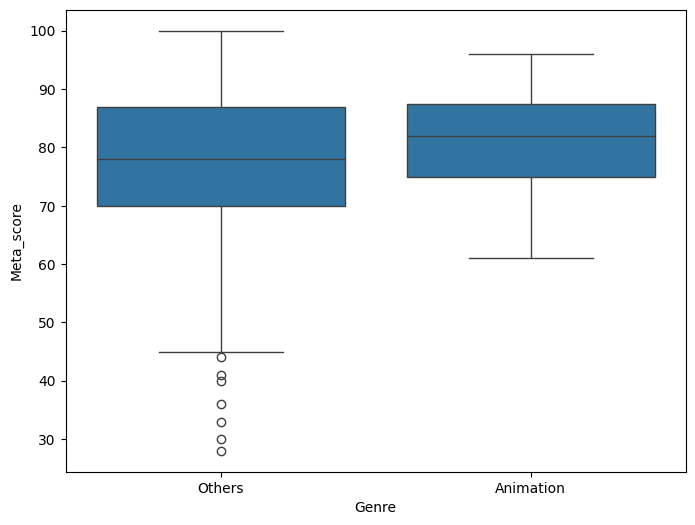

In [ ]:
plt.figure(figsize=(8,6))
sns.boxplot(x= animation_mask, y=df["Meta_score"])
plt.xticks([0,1], ["Others", "Animation"])
plt.show()

**O teste para o Metascore de animações e restante dos filmes indica que rejeitamos a hipótese nula de que as médias são iguais. Com um grau de confiança de 95%.**  
Já que pvalor obtido (0.00267) < 0.05  
**Na amostra, a média de metascore para Animações é igual a 8.1, enquanto para os outros filmes é igual a 7.766**

In [ ]:
# Teste para faturamento
animation_gross = df[animation_mask]["Gross_log"].dropna()
others_gross = df[~animation_mask]["Gross_log"].dropna()

stat, p_value = ttest_ind(animation_gross, others_gross, equal_var=False)

stat, p_value

(np.float64(1.9567077330275333), np.float64(0.054030584775964015))

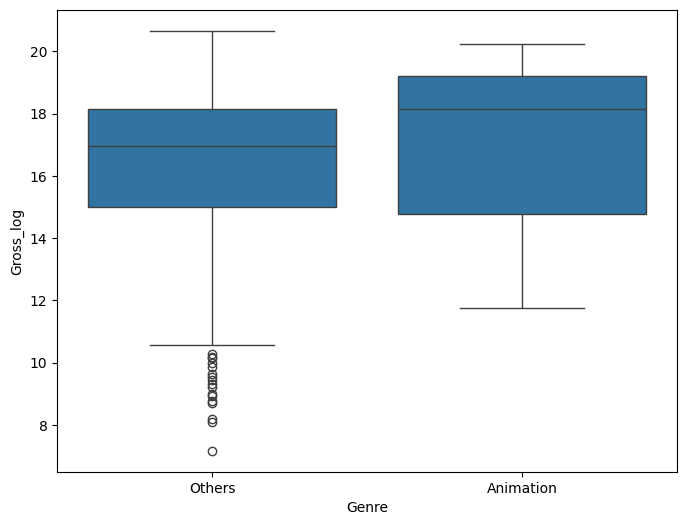

In [ ]:
# Com a transformação em log
plt.figure(figsize=(8,6))
sns.boxplot(x= animation_mask, y=df["Gross_log"])
plt.xticks([0,1], ["Others", "Animation"])
plt.show()

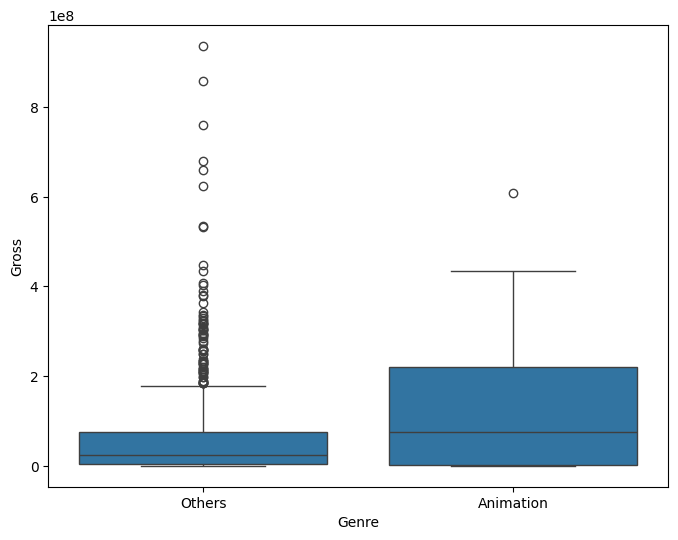

In [69]:
# Sem a transformação em log
plt.figure(figsize=(8,6))
sns.boxplot(x= animation_mask, y=df["Gross"])
plt.xticks([0,1], ["Others", "Animation"])
plt.show()

**O teste para o Faturamento de animações e restante dos filmes indica que não podemos rejeitar a hipótese nula de que as médias são iguais. Com um grau de confiança de 95%.**  
Já que pvalor obtido (0.054) > 0.05  
Na amostra, as animações faturaram em média aproximadamente o dobro do que os filmes que não são animação faturaram. Além de também possuir muito menos outliers. 

### Quais gêneros de filme fatura mais em média?

In [60]:
df_xgenre.groupby("Genre_list")["Gross"].mean().reset_index().sort_values(by='Gross', ascending=False).head(10)

,Genre_list,Gross
1,Adventure,1.657313e+08
16,Sci-Fi,1.480264e+08
0,Action,1.412393e+08
2,Animation,1.279675e+08
8,Fantasy,1.086168e+08
7,Family,9.293266e+07
4,Comedy,6.412530e+07
18,Thriller,5.867663e+07
10,History,5.553953e+07
3,Biography,5.525602e+07


Os principais gêneros de filme no quesito faturamento médio são: (valores aproximados)
- Aventura: $165.731.300,00
- Sci-Fi: $148.026.400,00
- Ação: $141.239.300,00
- Animações: $127.967.500,00
- Fantasia: $108.616.800,00
- Família: $92.932.660,00
- Comédia: $64.125.300,00

Uma variável que ajudaria a entender melhor essas tendências seria o orçamento médio que cada gênero de filme utiliza para seu lançamento

### Filmes sem metascore possuem menos número de votos? (menor público)

In [67]:
no_metascore = df[df["Meta_score"].isna()]
metascore_on = df[df["Meta_score"].notna()]

print(no_metascore["No_of_Votes"].describe())
print(metascore_on["No_of_Votes"].describe())

count       157.000000
mean      61631.554140
std       45477.754769
min       25088.000000
25%       33354.000000
50%       46700.000000
75%       67927.000000
max      311365.000000
Name: No_of_Votes, dtype: float64
count    8.420000e+02
mean     3.107763e+05
std      3.347535e+05
min      2.519800e+04
25%      7.097425e+04
50%      1.848530e+05
75%      4.385420e+05
max      2.303232e+06
Name: No_of_Votes, dtype: float64


Comparando os filmes que possuem um Metascore e os que possuem valor vazio:

Sem metascore:
- Média: 61631 votos
- Desvio Padrão: 45477 votos
- Mediana: 46700 votos
- Valor mínimo: 25088 votos
- Valor máximo: 311365 votos

Com metascore:
- Média: 310776 votos
- Desvio Padrão: 334753 Votos
- Mediana: 184853 votos
- Valor mínimo: 25198 votos
- Valor máximo: 2303232 votos

Pode-se perceber a diferença de magnitude entre ambos agrupamentos. Os filmes com metascore em geral possuem muito mais votos que os filmes sem metascore.  
Isso pode ser um indício de que filmes menos populares não possuem críticas suficietnes no metacritic para gerar seu score.  
Não aparenta ser uma regra, já que o valor mínimo de votos de usuários em um filme que possui metascore é parecido com a sua contraparte.

Outra situação que poderia ser explorada é o país de origem dos filmes sem metascore, já que alguns filmes indianos foram notados na fase exploratória (estes que possuem poucos votantes no imdb, verdade).

## 2. Perguntas

### A. Qual filme recomendaria para uma pessoa que você não conhece?

Levaria em consideração o IMDB_Rating e metascore, observando se há alguma diferença significativa entre o que o público e os críticos acham.  
Número de pessoas votantes seria considerado, pois um filme de maior alcance pode indicar um potencial maior acerto de recomendação.  
Por fim, levaria em conta a duração do filme, visto que nem todos estão dispostos a assistirem filmes muito longos.

Apartir desses princípios, observando os 10 melhores filmes pontudados em IMDB Rating, eu recomendaria o "Pulp Fiction".  
A Franquia The Godfather apesar de maiores notas, possuem filmes muito longos, que podem ser cansativos para algumas pessoas. LoTR também se encaixa nesta situaçaõ.
Já "12 Angry Men" apesar de um tempo de filme mais curto e excelentes notas, é um filme com menor alcance que os demais desse top 10.

De forma final, a recomendação seria "Pulp Fiction", porém, dependendo dos ajustes dos pesos dos parâmetros escolhidos poderia ser The Dark Knight e 12 Angry Men

A definição de um KPI com os devidos pesos poderia reduzir o viés humano de tomar essa decisão.

In [ ]:
columns = ["Series_Title", "IMDB_Rating", "Meta_score", "No_of_Votes", "Runtime"]

df[columns].sort_values(by="IMDB_Rating", ascending=False).head(10)


,Series_Title,IMDB_Rating,Meta_score,No_of_Votes,Runtime
1,The Godfather,9.2,100.0,1620367,175
2,The Dark Knight,9.0,84.0,2303232,152
3,The Godfather: Part II,9.0,90.0,1129952,202
4,12 Angry Men,9.0,96.0,689845,96
5,The Lord of the Rings: The Return of the King,8.9,94.0,1642758,201
6,Pulp Fiction,8.9,94.0,1826188,154
7,Schindler's List,8.9,94.0,1213505,195
8,Inception,8.8,74.0,2067042,148
9,Fight Club,8.8,66.0,1854740,139
10,The Lord of the Rings: The Fellowship of the Ring,8.8,92.0,1661481,178


### B. Quais são os principais fatores que estão relacionados com alta expectativa de faturamento de um filme?

O número de votos possui uma correlação moderada com o faturamento, uma explicação é que essa variável indica que o filme é popular e possui um alcance maior.  
Já os diretores e atores envolvidos nos filmes podem aumentar a expectativa de faturamento do filme simplesmente pela marca que esses indivíduos representam na industria. Profissionais mais prestigiados e reconhecidos carregam uma carga de suas performances históricas.  
Também, como explorado anteriormente, os gêneros que os filmes contemplam podem sim indicar uma maior ou menor tendência de faturamento.

### C. Quais insights podem ser tirados com a coluna Overview? É possível inferir o gênero do filme a partir dessa coluna?

A coluna overview trás uma breve sinopse de cada filme.
Dentro dessas sinopses podem ser extraídas as palavras de maior frequência e suas correlações com outras variáveis.  
Quanto à inferência de gênero do filme através do overview, sim é possível fazer isso utilizando técnicas de NLP.

## 3. Explicando previsão da nota do imdb

**Quais variáveis e/ou suas transformações você utilizou e por quê?**  
As variáveis numéricas: 'Released_Year', 'Runtime', 'Meta_score', 'Votes_log', 'Gross_log', onde número de votos e faturamento foi utilizado a transformação em log para mitigar outliers.  
Variável categórica dos gêneros de filme foi transformada em diversas colunas booleanas para melhor aproveitamento do modelo.  
Para o tipo de modelo utilizado, as variáveis em formato numérico são preferidas

**Qual tipo de problema estamos resolvendo (regressão, classificação)?**  
Estamos resolvendo um problema de regressão, tentando chegar em um valor numérico contínuo.

**Qual modelo melhor se aproxima dos dados e quais seus prós e contras?**  
Random Forest foi o escolhido, pois funciona bem com as variáveis categóricas e numéricas, resistente a outliers e possuir mais facilidade de treinamento.  
O revés é a dificuldade de interpretação de cada árvore presente dentro da "floresta"

**Qual medida de performance do modelo foi escolhida e por quê?**  
MAE e RMSE  
Com MAE, fica fácil de interpretar o valor que significa a distância média das previsões para o valor real.  
Já RMSE ajuda a visualizar com penalidade a erros grandes, causados por outliers

## 4. Prevendo nota IMDB

In [84]:
dummies = pd.get_dummies(df_xgenre["Genre_list"], prefix="genre")
df_genres = dummies.groupby(df_xgenre.index).sum()
df_model = df.join(df_genres)

df_model.columns

Index(['Series_Title', 'Released_Year', 'Certificate', 'Runtime', 'Genre',
       'IMDB_Rating', 'Overview', 'Meta_score', 'Director', 'Star1', 'Star2',
       'Star3', 'Star4', 'No_of_Votes', 'Gross', 'Genre_list', 'Votes_log',
       'Gross_log', 'genre_Action', 'genre_Adventure', 'genre_Animation',
       'genre_Biography', 'genre_Comedy', 'genre_Crime', 'genre_Drama',
       'genre_Family', 'genre_Fantasy', 'genre_Film-Noir', 'genre_History',
       'genre_Horror', 'genre_Music', 'genre_Musical', 'genre_Mystery',
       'genre_Romance', 'genre_Sci-Fi', 'genre_Sport', 'genre_Thriller',
       'genre_War', 'genre_Western'],
      dtype='object')

In [ ]:
df_model["Meta_score"] = df_model["Meta_score"].fillna(df["Meta_score"].mean())
df_model = df_model.dropna(subset=["Gross_log", "Released_Year"])

X = df_model.drop(columns=["Series_Title", "Certificate", "Genre", "Overview", "Director", "Star1", "Star2", "Star3", "Star4", "No_of_Votes", "Gross", "Genre_list", "IMDB_Rating"])
y = df_model["IMDB_Rating"]

In [95]:
rf = RandomForestRegressor(n_estimators=200, random_state=42)

rmse_scores = -cross_val_score(rf, X, y, cv=5, scoring="neg_root_mean_squared_error")
print("5-fold RMSE:", rmse_scores)
print("Mean RMSE:", rmse_scores.mean())
print("Std RMSE:", rmse_scores.std())

# 5-fold MAE
mae_scores = -cross_val_score(rf, X, y, cv=5, scoring="neg_mean_absolute_error")
print("5-fold MAE:", mae_scores)
print("Mean MAE:", mae_scores.mean())

5-fold RMSE: [0.46106833 0.20137108 0.13783506 0.16390061 0.26885957]
Mean RMSE: 0.24660693058165184
Std RMSE: 0.11593688458281158
5-fold MAE: [0.41594277 0.17949398 0.11299699 0.12691265 0.25775152]
Mean MAE: 0.2186195801387377


Em média, as predições ficam 0.22 (valor de MAE) de distancia do valor real do IMDB Rating, mas há casos que erro pode ser um pouco maior. Já que RMSE > MAE, porém aparentam serem próximos.

In [ ]:
# Treinando modelo final para adicionar o novo filme
rf_final = RandomForestRegressor(n_estimators=200, random_state=42)
rf_final.fit(X, y)

,n_estimators,200
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


### Adicionando a entrada

In [ ]:
# Adicionando novo filme no formato correto para o modelo
new_entry = {'Series_Title': 'The Shawshank Redemption',
 'Released_Year': 1994,
 'Certificate': 'A',
 'Runtime': 142,
 'Genre': 'Drama',
 'Overview': 'Two imprisoned men bond over a number of years, finding solace and eventual redemption through acts of common decency.',
 'Meta_score': 80.0,
 'Director': 'Frank Darabont',
 'Star1': 'Tim Robbins',
 'Star2': 'Morgan Freeman',
 'Star3': 'Bob Gunton',
 'Star4': 'William Sadler',
 'No_of_Votes': 2343110,
 'Gross': 28341469.0,
 'Votes_log': 0.0,
 'Gross_log': 0.0, 
 'genre_Action': 0,
 'genre_Adventure': 0,
 'genre_Animation': 0,
 'genre_Biography': 0,
 'genre_Comedy': 0,
 'genre_Crime': 0,
 'genre_Drama': 1,
 'genre_Family': 0,
 'genre_Fantasy': 0, 
 'genre_Film-Noir': 0, 
 'genre_History': 0,
 'genre_Horror': 0,
 'genre_Music': 0,
 'genre_Musical': 0,
 'genre_Mystery': 0,
 'genre_Romance': 0,
 'genre_Sci-Fi': 0, 
 'genre_Sport': 0,
 'genre_Thriller': 0,
 'genre_War': 0, 
 'genre_Western': 0}

new_df = pd.DataFrame([new_entry])
new_df["Gross_log"] = np.log1p(new_df["Gross"])
new_df["Votes_log"] = np.log1p(new_df["No_of_Votes"])

new_df = new_df.drop(columns=["Series_Title", "Certificate", "Genre", "Overview", "Director", "Star1", "Star2", "Star3", "Star4", "No_of_Votes", "Gross"])

new_df.columns, X.columns


(Index(['Released_Year', 'Runtime', 'Meta_score', 'Votes_log', 'Gross_log',
        'genre_Action', 'genre_Adventure', 'genre_Animation', 'genre_Biography',
        'genre_Comedy', 'genre_Crime', 'genre_Drama', 'genre_Family',
        'genre_Fantasy', 'genre_Film-Noir', 'genre_History', 'genre_Horror',
        'genre_Music', 'genre_Musical', 'genre_Mystery', 'genre_Romance',
        'genre_Sci-Fi', 'genre_Sport', 'genre_Thriller', 'genre_War',
        'genre_Western'],
       dtype='object'),
 Index(['Released_Year', 'Runtime', 'Meta_score', 'Votes_log', 'Gross_log',
        'genre_Action', 'genre_Adventure', 'genre_Animation', 'genre_Biography',
        'genre_Comedy', 'genre_Crime', 'genre_Drama', 'genre_Family',
        'genre_Fantasy', 'genre_Film-Noir', 'genre_History', 'genre_Horror',
        'genre_Music', 'genre_Musical', 'genre_Mystery', 'genre_Romance',
        'genre_Sci-Fi', 'genre_Sport', 'genre_Thriller', 'genre_War',
        'genre_Western'],
       dtype='object'))

In [136]:
predicted_rating = rf_final.predict(new_df)
print("Predicted IMDB Rating: ", round(predicted_rating[0], 1))

Predicted IMDB Rating:  8.8


**Qual seria a nota do IMDB?**  
O IMDB Rating predito para essa entrada de Shawshank Redemption foi de 8.8

### Salvando o arquivo .pkl

In [139]:
joblib.dump(rf_final, "random_forest.pkl")

['random_forest.pkl']